In [51]:
import pennylane as qml
from pennylane.templates.state_preparations.mottonen import compute_theta, gray_code
import numpy as np
import matplotlib.pyplot as plt

In [97]:
np.random.seed(42)
n = 2

A = np.random.randn(2**n, 2**n)
A = A / np.max(np.abs(A))
A

array([[ 0.2596139 , -0.07226558,  0.33852257,  0.79603072],
       [-0.12238321, -0.12237463,  0.82539545,  0.40110942],
       [-0.2453767 ,  0.28357584, -0.24221109, -0.24341952],
       [ 0.12646463, -1.        , -0.90155001, -0.29388665]])

In [98]:
alphas = np.arccos(A).flatten()
alphas

array([1.30817395, 1.64312495, 1.22545001, 0.6500877 , 1.69348711,
       1.69347847, 0.59989402, 1.15806868, 1.81870458, 1.28327535,
       1.81544048, 1.81668619, 1.44399215, 3.14159265, 2.69413498,
       1.86908685])

In [99]:
thetas = compute_theta(alphas)
thetas

array([ 1.61591738e+00, -4.10077233e-02, -1.46131481e-01,  1.37311270e-01,
       -6.91094627e-02,  9.94266827e-02,  1.37832077e-01, -1.70799482e-01,
        1.31038023e-01, -3.80099096e-02, -2.82988762e-01, -4.57485818e-05,
        2.00784240e-01,  1.02115231e-01,  1.28838470e-03, -3.69446772e-01])

In [100]:
ancilla_wires = ["ancilla"]

s = int(np.log2(A.shape[0]))
print(s)
wires_i = [f"i{index}" for index in range(s)]
wires_j = [f"j{index}" for index in range(s)]

2


In [101]:
code = gray_code(2 * np.log2(len(A)))
n_selections = len(code)

control_wires = [
    int(np.log2(int(code[i], 2) ^ int(code[(i + 1) % n_selections], 2)))
    for i in range(n_selections)
]

wire_map = {control_index: wire for control_index, wire in enumerate(wires_j + wires_i)}

In [102]:
print(f"Control wires: {control_wires}")
print(f"Wire map: {wire_map}")

Control wires: [0, 1, 0, 2, 0, 1, 0, 3, 0, 1, 0, 2, 0, 1, 0, 3]
Wire map: {0: 'j0', 1: 'j1', 2: 'i0', 3: 'i1'}


In [127]:
def UA(thetas, control_wires, ancilla):
    for i, (theta, control_index) in enumerate(zip(thetas, control_wires)):
        qml.RZ(2 * theta, wires=ancilla)
        # qml.Snapshot(f"RY {i}")
        # if "j" not in wire_map[control_index]:
        qml.CNOT(wires=[wire_map[control_index]] + ancilla)
        # qml.Snapshot(f"CNOT {i}")


def UB(wires_i, wires_j):
    for i, (w_i, w_j) in enumerate(zip(wires_i, wires_j)):
        qml.SWAP(wires=[w_i, w_j])
        # qml.Snapshot(f"SWAP {i}")


def HN(input_wires):
    for w in input_wires:
        qml.Hadamard(wires=w)

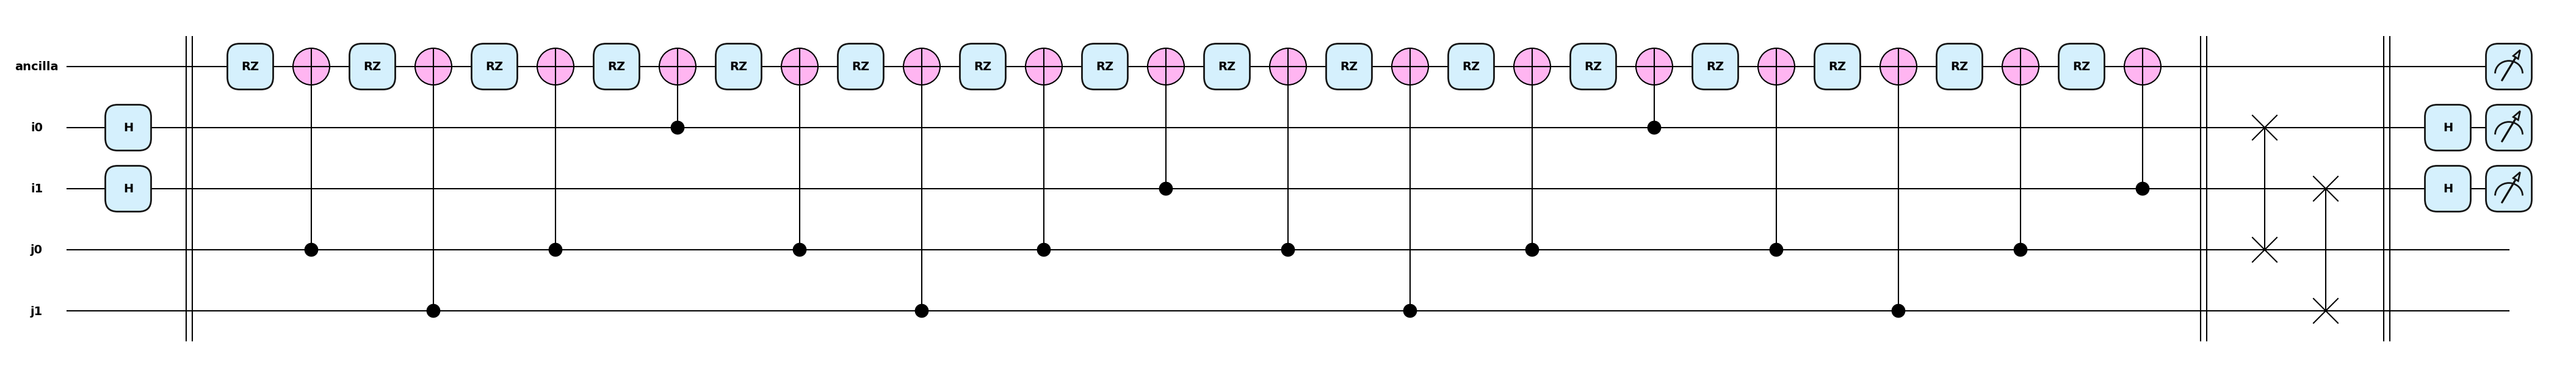

In [128]:
dev = qml.device("default.qubit", wires=ancilla_wires + wires_i + wires_j)


@qml.qnode(dev)
def circuit():
    # qml.Snapshot("Initial State")
    HN(wires_i)
    qml.Barrier()  # to separate the sections in the circuit
    # qml.Snapshot("Barrier 1")
    UA(thetas, control_wires, ancilla_wires)
    qml.Barrier()
    # qml.Snapshot("Barrier 2")
    UB(wires_i, wires_j)
    qml.Barrier()
    # qml.Snapshot("Barrier 3")
    HN(wires_i)
    # qml.Snapshot("Final State")
    return qml.probs(wires=ancilla_wires + wires_i)


qml.draw_mpl(circuit, style="pennylane")()
plt.show()

In [119]:
snap = qml.snapshots(circuit)()


# Function to convert an index to Dirac notation
def state_to_dirac(index, num_qubits):
    binary_rep = format(index, f"0{num_qubits}b")
    return f"|{binary_rep}⟩"


# Function to display states with amplitudes in Dirac notation
def display_states_in_dirac(state_tensor, num_qubits):
    for i, amplitude in enumerate(state_tensor):
        dirac_notation = state_to_dirac(i, num_qubits)
        print(f"{dirac_notation} : Amplitude = {amplitude}")


num_qubits = 3

# Display each snapshot in Dirac notation
for snapshot_name, state_tensor in snap.items():
    print(f"\n{snapshot_name}:")
    display_states_in_dirac(state_tensor, num_qubits)


Initial State:
|000⟩ : Amplitude = (1+0j)
|001⟩ : Amplitude = 0j
|010⟩ : Amplitude = 0j
|011⟩ : Amplitude = 0j
|100⟩ : Amplitude = 0j
|101⟩ : Amplitude = 0j
|110⟩ : Amplitude = 0j
|111⟩ : Amplitude = 0j
|1000⟩ : Amplitude = 0j
|1001⟩ : Amplitude = 0j
|1010⟩ : Amplitude = 0j
|1011⟩ : Amplitude = 0j
|1100⟩ : Amplitude = 0j
|1101⟩ : Amplitude = 0j
|1110⟩ : Amplitude = 0j
|1111⟩ : Amplitude = 0j
|10000⟩ : Amplitude = 0j
|10001⟩ : Amplitude = 0j
|10010⟩ : Amplitude = 0j
|10011⟩ : Amplitude = 0j
|10100⟩ : Amplitude = 0j
|10101⟩ : Amplitude = 0j
|10110⟩ : Amplitude = 0j
|10111⟩ : Amplitude = 0j
|11000⟩ : Amplitude = 0j
|11001⟩ : Amplitude = 0j
|11010⟩ : Amplitude = 0j
|11011⟩ : Amplitude = 0j
|11100⟩ : Amplitude = 0j
|11101⟩ : Amplitude = 0j
|11110⟩ : Amplitude = 0j
|11111⟩ : Amplitude = 0j

Barrier 1:
|000⟩ : Amplitude = (0.4999999999999999+0j)
|001⟩ : Amplitude = 0j
|010⟩ : Amplitude = 0j
|011⟩ : Amplitude = 0j
|100⟩ : Amplitude = 0j
|101⟩ : Amplitude = 0j
|110⟩ : Amplitude = 0j
|111⟩ : Am

|000⟩ : Amplitude = 0.0718032919630455
|001⟩ : Amplitude = 0.0718032919630455
|010⟩ : Amplitude = 0.42819670803695453
|011⟩ : Amplitude = 0.42819670803695453

In [129]:
print(f"Original matrix:\n{A}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
M = len(A) * qml.matrix(circuit, wire_order=wire_order)().real[0 : len(A), 0 : len(A)]
print(f"Block-encoded matrix:\n{M}", "\n")

Original matrix:
[[ 0.2596139  -0.07226558  0.33852257  0.79603072]
 [-0.12238321 -0.12237463  0.82539545  0.40110942]
 [-0.2453767   0.28357584 -0.24221109 -0.24341952]
 [ 0.12646463 -1.         -0.90155001 -0.29388665]] 

Block-encoded matrix:
[[ 0.2596139  -0.07226558  0.33852257  0.79603072]
 [-0.12238321 -0.12237463  0.82539545  0.40110942]
 [-0.2453767   0.28357584 -0.24221109 -0.24341952]
 [ 0.12646463 -1.         -0.90155001 -0.29388665]] 



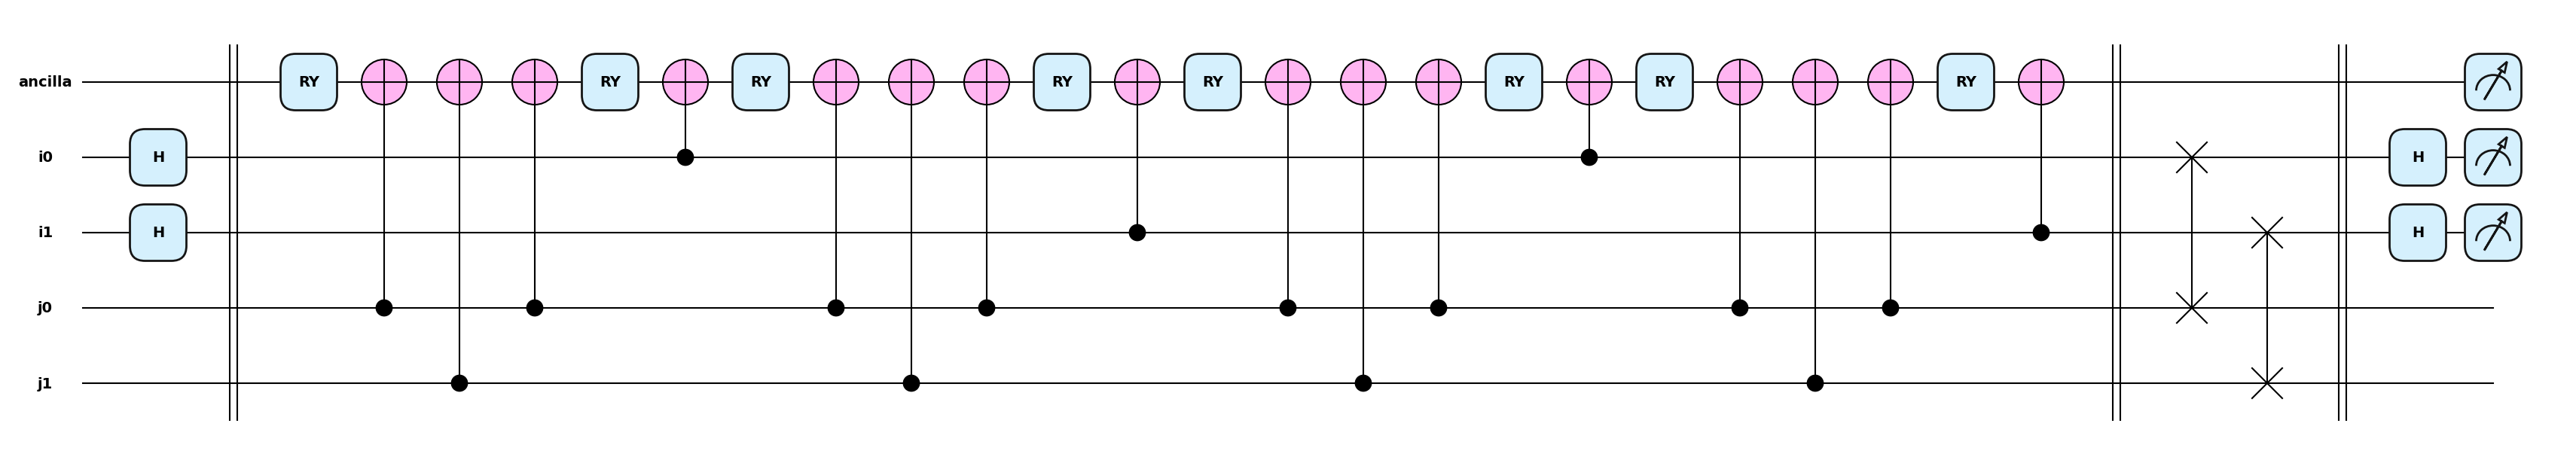

In [10]:
tolerance = 0.01


def UA(thetas, control_wires, ancilla):
    for theta, control_index in zip(thetas, control_wires):
        if abs(2 * theta) > tolerance:
            qml.RY(2 * theta, wires=ancilla)
        qml.CNOT(wires=[wire_map[control_index]] + ancilla)


qml.draw_mpl(circuit, style="pennylane")()
plt.show()

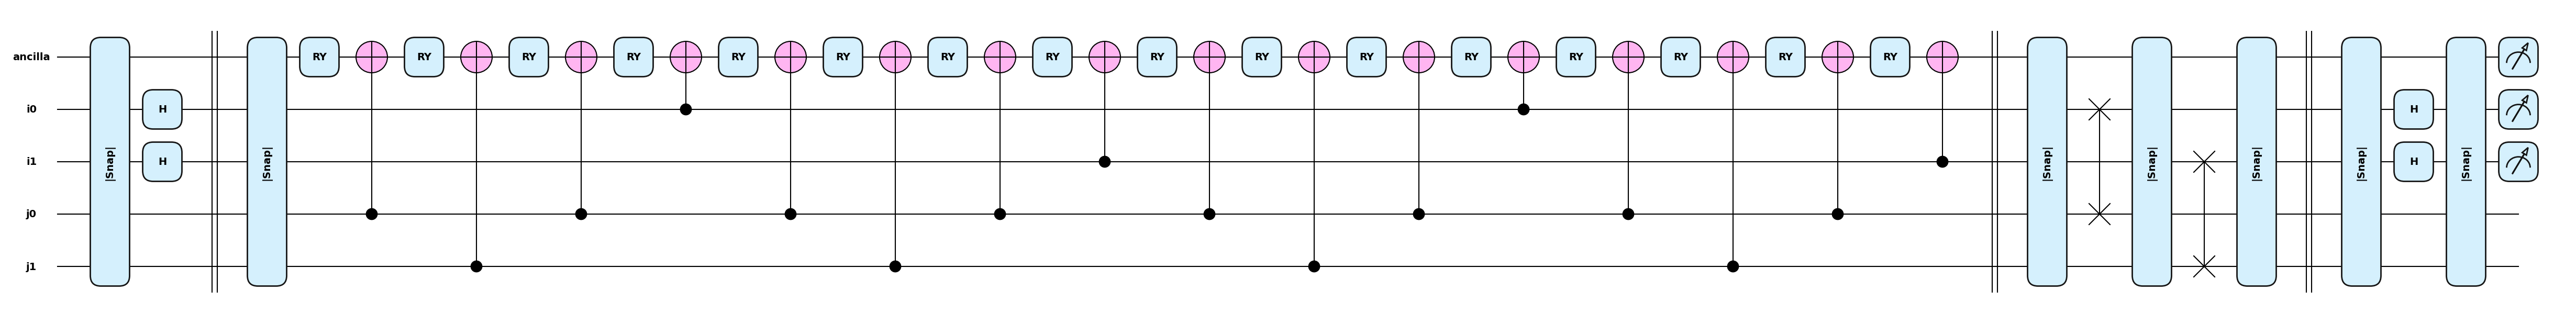

Original matrix:
[[ 0.2596139  -0.07226558  0.33852257  0.79603072]
 [-0.12238321 -0.12237463  0.82539545  0.40110942]
 [-0.2453767   0.28357584 -0.24221109 -0.24341952]
 [ 0.12646463 -1.         -0.90155001 -0.29388665]] 



MatrixUndefinedError: 

In [121]:
tolerance = 0


def UA(thetas, control_wires, ancilla):
    nots = []
    for theta, control_index in zip(thetas, control_wires):
        if abs(2 * theta) > tolerance:
            for c_wire in nots:
                qml.CNOT(wires=[c_wire] + ancilla)
            qml.RY(2 * theta, wires=ancilla)
            nots = []
        if (cw := wire_map[control_index]) in nots:
            del nots[nots.index(cw)]
        else:
            nots.append(wire_map[control_index])
    for c_wire in nots:
        qml.CNOT([c_wire] + ancilla)


qml.draw_mpl(circuit, style="pennylane")()
plt.show()

print(f"Original matrix:\n{A}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
M = len(A) * qml.matrix(circuit, wire_order=wire_order)().real[0 : len(A), 0 : len(A)]
print(f"Block-encoded matrix:\n{M}", "\n")

In [12]:
from pennylane.templates.embeddings import amplitude

In [26]:
# input_matrix = np.array(
#     [
#         [-1.3649, -0.7208, 0.0784, 0.8478, -0.3068, 0.5320, 0.4568, 1.3797],
#         [1.2722, -0.7537, -1.0356, -0.0418, -0.2866, 0.0816, -1.2731, 0.7053],
#         [-0.0978, 0.8246, 1.6583, -0.1244, 0.1140, 0.3369, 0.1999, -0.8536],
#         [0.0305, -0.3220, -0.3374, -0.5319, 0.2376, 0.7346, 0.7524, 1.1421],
#         [-0.8208, -0.9572, 0.2941, 0.0352, -0.5225, -0.4629, 0.7994, 0.2063],
#         [-2.5770, -0.4539, -0.1389, 0.5110, 0.8750, 0.2704, -1.2357, 0.6271],
#         [1.5449, -1.8197, 1.4623, -1.7419, -0.5118, -0.9060, -1.2052, 1.2075],
#         [-0.4299, 1.4124, 0.6805, -0.4560, 0.0076, 0.2352, -0.5625, -0.1918],
#     ]
# )

np.random.seed(42)
n = 1

input_matrix = np.random.randn(2**n, 2**n)

ancilla_wires = ["ancilla"]

s = int(np.log2(input_matrix.shape[0]))
print(input_matrix.shape)
print("Elements in the matrix: ", 2**n * 2**n)
print(s)
wires_i = [f"i{index}" for index in range(s)]
wires_j = [f"j{index}" for index in range(s)]


input_matrix = input_matrix / np.max(np.abs(input_matrix))
dev = qml.device("default.qubit", wires=ancilla_wires + wires_i + wires_j)


@qml.qnode(dev)
def example_circuit():
    qml.FABLE(input_matrix, wires=ancilla_wires + wires_i + wires_j, tol=0)
    return qml.state()

(2, 2)
Elements in the matrix:  4
1


(<Figure size 1300x400 with 1 Axes>, <Axes: >)


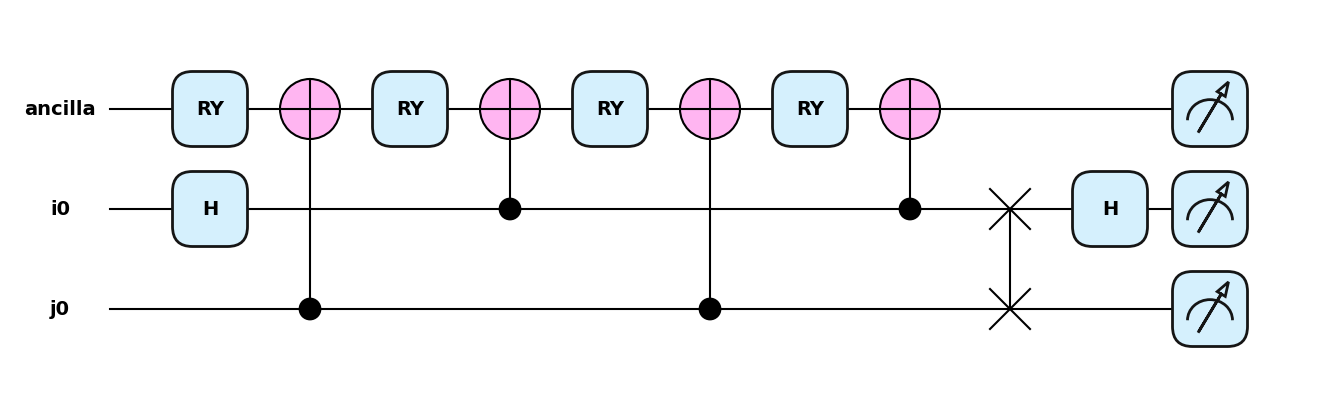

In [25]:
print(qml.draw_mpl(example_circuit, style="pennylane", level=None)())

In [23]:
specs_func = qml.specs(example_circuit)
specs_func()

{'resources': Resources(num_wires=3, num_gates=1, gate_types=defaultdict(<class 'int'>, {'FABLE': 1}), gate_sizes=defaultdict(<class 'int'>, {3: 1}), depth=1, shots=Shots(total_shots=None, shot_vector=())),
 'errors': {},
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_trainable_params': 0,
 'num_device_wires': 3,
 'num_tape_wires': 3,
 'device_name': 'default.qubit',
 'level': 'gradient',
 'gradient_options': {},
 'interface': 'auto',
 'diff_method': 'best',
 'gradient_fn': 'backprop'}

In [15]:
s = int(np.ceil(np.log2(max(len(input_matrix), len(input_matrix[0])))))
expected = 2**s * qml.matrix(example_circuit)().real[0 : 2**s, 0 : 2**s]
print(f"Block-encoded matrix:\n{expected}")

Block-encoded matrix:
[[ 0.32613553 -0.0907824 ]
 [ 0.42526319  1.        ]]


In [16]:
input_matrix = input_matrix / np.max(np.abs(input_matrix))
print(f"Input matrix:\n{input_matrix}", "\n")
dev = qml.device("default.qubit", wires=ancilla_wires + wires_i + wires_j)


@qml.qnode(dev)
def example_circuit():
    qml.BlockEncode(input_matrix, wires=ancilla_wires + wires_i + wires_j)
    return qml.state()

Input matrix:
[[ 0.32613553 -0.0907824 ]
 [ 0.42526319  1.        ]] 



(<Figure size 400x400 with 1 Axes>, <Axes: >)


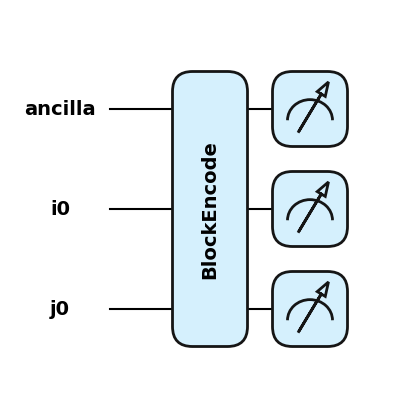

In [17]:
print(qml.draw_mpl(example_circuit, style="pennylane", level="top")())

In [18]:
n = 4

print(2**n * 2**n)

256
